In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error

In [171]:
housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)

# Bereinigung und Feature Engeneering

# für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]

# monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1

# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]

# Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
housing_data["Zustandf"] = [int(x/2) + x%2 for x in housing_data["Zustand"]]

# Alle Zustände werden von 1...X auf 0....X-1 geschoben
housing_data["HeizungsqualitaetN"] = [ x-1 for x in housing_data["Heizungsqualitaet"]]
housing_data["ZustandN"] = [ x-1 for x in housing_data["Zustandf"]]
housing_data["FassadeN"] = [ x-1 for x in housing_data["Zustand Fassade"]]
housing_data["KuecheN"] = [ x-1 for x in housing_data["Kuechenqualitaet"]]

# Klimaanlage Ja/Nein  -> 1/0
housing_data["Klimaanlage"] = [1 if x == "Y" else 0 for x in housing_data["Klimaanlage"]]

# Besonders Große Daten beim Preis rausschmeißen
max_value = housing_data["Preis"].unique()[-1:][0]
housing_data[housing_data["Preis"] != max_value]


# NA in Garage Typ wird zu "Keine Garage"
housing_data["Garage Typ"] = ['keine Garage' if x=='NA' else x for x in housing_data["Garage Typ"]]


print(housing_data.keys())

Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis',
       'Preisproqm', 'Monate', 'Zustandf', 'HeizungsqualitaetN', 'ZustandN',
       'FassadeN', 'KuecheN'],
      dtype='object')


In [190]:
#Extract X and y from dataset
# Set features to test
features = [ "Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN","Klimaanlage", "Gebaut", "Garagenkapazitaet"]
# Predictvalue
predict= "Preis"

X = {}
for feature in features:
    X[feature] = housing_data[feature]
X = pd.DataFrame(X)

Y = pd.DataFrame(housing_data[predict])

In [193]:
#Prepare data

#Most important features 
#air conditioning, heater quality, kitchen quality, state of house, state of facade 

#Encode features (Label ord One-Hot)

#Separate into training- and testdata
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
 #Regression

reg = linear_model.LinearRegression()
ridge = linear_model.Ridge(alpha=0.05)
lasso = linear_model.Lasso(alpha=0.05)

reg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
#Validation
y_pred_reg = reg.predict(X_test)
y_pred_ridge = reg.predict(X_test)
y_pred_lasso = reg.predict(X_test)


print(mean_squared_error(y_test, y_pred_reg), mean_squared_error(y_test, y_pred_ridge), max_error(y_test, y_pred_lasso))

(1600, 7) (1600, 1) (400, 7) (400, 1)
1073886306.3988008 1073886306.3988008 183529.000655422


(array([  2.,   1.,   8.,  59., 174., 120.,  28.,   4.,   3.,   1.]),
 array([0.03855122, 0.23715942, 0.43576762, 0.63437582, 0.83298402,
        1.03159223, 1.23020043, 1.42880863, 1.62741683, 1.82602503,
        2.02463323]),
 <BarContainer object of 10 artists>)

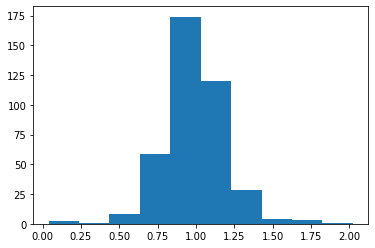

In [192]:
plt.hist(y_pred_reg / y_test)

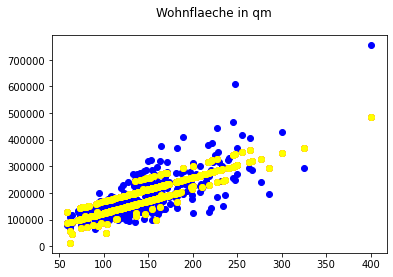

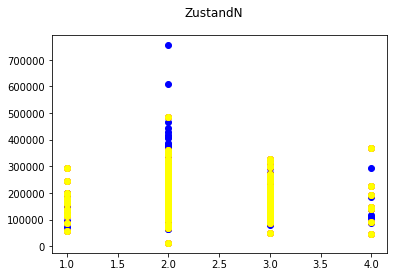

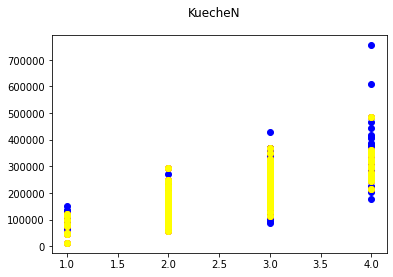

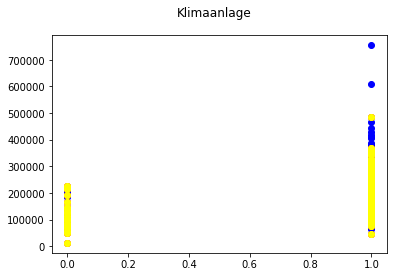

In [155]:
for feature in features:
    plt.scatter(X_test[feature], y_test, c="blue")
    plt.scatter(X_test[feature], y_pred_reg, c="red")
    plt.scatter(X_test[feature], y_pred_ridge, c="orange")
    plt.scatter(X_test[feature], y_pred_lasso, c="yellow")
    plt.suptitle(feature)
    plt.show()
